# Проект: вариант 4
## Задание 1
Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Данные:

* active_users – информация о пользователях, которые посещали приложение во время эксперимента
* groups – разбивка пользователей на контрольную (А) и тестовую (В) группы
* purchases – данные о транзакциях (оплатах) пользователей приложения во время эксперимента



Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import StratifiedTable
import os
from scipy import stats
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

Функции, используемые в коде

In [2]:
def paid_user(row):
    if row.revenue > 0:
        return 1
    else:
        return 0

In [113]:
def comparison_A_B(metric_B, metric_A):
    if metric_B > metric_A:
        diff = (metric_B - metric_A)/metric_A *100
        print('Увеличилось на ', round(diff,2), '% в тестовой группе по сравнению с контрольной', sep='')
    elif metric_B == metric_A:
        print('Не изменилось')
    else:
        diff = (metric_A - metric_B)/metric_A *100
        print('Уменьшилось на ', round(diff,2), '% в тестовой группе по сравнению с контрольной', sep='')

In [4]:
def comparisson_Pvalue(Pvalue):
    if Pvalue > 0.05:
        print('По полученному p-value > 0.05 не можем отклонить нулевую гипотезу, т.е. распределения выборок не имеют статически значимых различий.')
    else:
        print('По полученному p-value < 0.05 можем отклонить нулевую гипотезу, т.е. распределения выборок имеют статически значимые различия.')


In [5]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Загрузка данных

In [6]:
os.getcwd()

'/home/jupyter-k.ezdakova-3/final_project'

In [7]:
path_active_users = '/home/jupyter-k.ezdakova-3/final_project/active_users.csv'
path_groups = '/home/jupyter-k.ezdakova-3/final_project/groups.csv'
path_purchases = '/home/jupyter-k.ezdakova-3/final_project/purchases.csv'

In [8]:
active_users = pd.read_csv(path_active_users)
groups       = pd.read_csv(path_groups)
purchases    = pd.read_csv(path_purchases)

active_users.head(2)

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male


Предпросмотр данных

In [9]:
active_users.user_id.nunique()

8341

In [10]:
groups.head(2)

,user_id,group
0,9149,B
1,9150,B


In [11]:
groups.user_id.nunique()

74576

In [12]:
users_A_groups = groups.query('group == "A"').user_id.nunique()
print('Количество пользователей в группе А:', users_A_groups)

Количество пользователей в группе А: 14693


In [13]:
users_B_groups = groups.query('group == "B"').user_id.nunique()
print('Количество пользователей в группе B:', users_B_groups)

Количество пользователей в группе B: 59883


In [14]:
print('Соотношение количества пользователей в группе а к б:', round(users_A_groups/users_B_groups *100, 1), '%')
#Соотношение юзеров а к б

Соотношение количества пользователей в группе а к б: 24.5 %


In [15]:
print('Количество уникальных пользователей в датафрейме purchase:', purchases.user_id.nunique())

Количество уникальных пользователей в датафрейме purchase: 541


In [16]:
purchases.head(2)

,user_id,revenue
0,4412,1000.0
1,9000,701.0


In [17]:
groups.shape

(74576, 2)

In [18]:
purchases.shape

(541, 2)

In [19]:
active_users.shape

(8341, 4)

#### Условие задания 
 Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

Соединение исходных таблиц в одну под названием test

In [26]:
test = active_users.merge(purchases, how ='outer', on = ['user_id']) 

In [27]:
test = test.merge(groups, how ='inner', on = ['user_id']) 

test.head(2)

,user_id,country,platform,sex,revenue,group
0,8029,Russia,ios,male,NaN,B
1,1735,Sweden,ios,male,NaN,B


In [28]:
test.shape

(8490, 6)

In [29]:
test['revenue'] = test['revenue'].fillna(0)

In [30]:
test.head()

,user_id,country,platform,sex,revenue,group
0,8029,Russia,ios,male,0.0,B
1,1735,Sweden,ios,male,0.0,B
2,7697,Russia,android,male,0.0,B
3,1421,Sweden,android,female,0.0,B
4,1704,Russia,ios,male,0.0,B


In [31]:
test['paid_user'] = test.apply(lambda row: paid_user(row), axis=1)

test.head(3)

,user_id,country,platform,sex,revenue,group,paid_user
0,8029,Russia,ios,male,0.0,B,0
1,1735,Sweden,ios,male,0.0,B,0
2,7697,Russia,android,male,0.0,B,0


In [32]:
test.dtypes

user_id        int64
country       object
platform      object
sex           object
revenue      float64
group         object
paid_user      int64
dtype: object

Создаем удобные фильтры

In [33]:
test['group'].unique()

array(['B', 'A'], dtype=object)

In [34]:
is_control = test['group'] == 'A'
is_test    = test['group'] == 'B'
is_revenue_more_0 = test['revenue'] > 0

# создаем фильтры для двух групп контрольной и тестовой

Преданализ по группам А и В

In [35]:
users_A_active = test[is_control].user_id.nunique()
print('Количество юзеров в группе А:', users_A_active)

Количество юзеров в группе А: 1567


In [36]:
users_B_active = test[is_test].user_id.nunique()
print('Количество юзеров в группе B:', users_B_active)

Количество юзеров в группе B: 6923


In [37]:
users_A_active/users_B_active

0.22634695941066013

In [38]:
users_A_active_with_revenue = test[is_revenue_more_0].query('group == "A"').user_id.nunique()
print('Количество клиентов в группе А:', users_A_active_with_revenue)

Количество клиентов в группе А: 107


In [39]:
users_B_active_with_revenue = test[is_revenue_more_0].query('group == "B"').user_id.nunique()
print('Количество клиентов в группе B:', users_B_active_with_revenue)

Количество клиентов в группе B: 434


In [40]:
users_A_active_with_revenue/users_B_active_with_revenue

0.2465437788018433

In [41]:
b = test[is_test & is_revenue_more_0].revenue
a = test[is_control & is_revenue_more_0].revenue
b.name, a.name = 'Test', 'Control'

Визуализация распределений дохода в зависимости от групп 

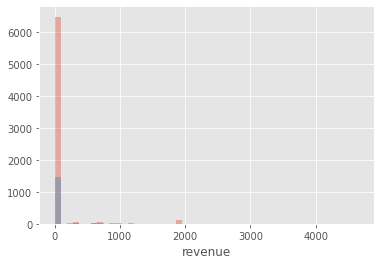

In [42]:
sns.distplot(test[is_test].revenue, kde = False)
sns.distplot(test[is_control].revenue, kde = False)

Из рисунка видно, что распределения не нормальны (очень много нулевых значений, и вследствии этого наблюдается сильное смещение влево). Но проверим на нормальность тестом Шапиро-Уилка.

In [43]:
mean_control = test[is_control].revenue.mean()
std_control  = test[is_control].revenue.std()

print('Среднее значение дохода в котрольной группе', round(mean_control,1), 'со стандартным отклонением', round(std_control,1))

Среднее значение дохода в котрольной группе 59.5 со стандартным отклонением 305.5


In [44]:
stats.shapiro(test[is_control].revenue.sample(1000, random_state=17))

(0.19503062963485718, 0.0)

In [45]:
mean_test = test[is_test].revenue.mean()
std_test  = test[is_test].revenue.std()

print('Среднее значение дохода в тестовой группе', round(mean_test,1), 'со стандартным отклонением', round(std_test,1))

Среднее значение дохода в тестовой группе 70.1 со стандартным отклонением 328.6


In [46]:
stats.shapiro(test[is_test].revenue.sample(1000, random_state=17))

(0.23139363527297974, 0.0)

На основании теста Шапиро-Уилка, делаем вывод, что распределение дохода в группах A, B -  не нормально (p-value < 0.05)

Построение распределений для тестовой и контрольной групп с доходом больше 0, т.е. распределения выручки только для клиентов

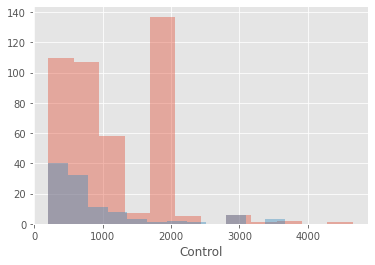

In [47]:
sns.distplot(b, kde = False)
sns.distplot(a, kde = False)

Text(0, 0.5, 'Доход')

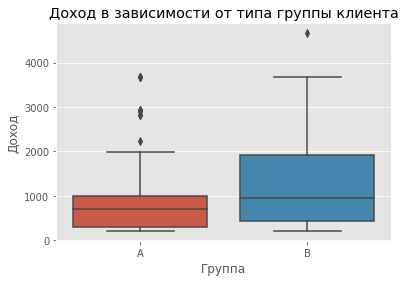

In [48]:
sns.boxplot(x='group', y='revenue', data=test[is_revenue_more_0])
plt.title('Доход в зависимости от типа группы клиента')
plt.xlabel('Группа')
plt.ylabel('Доход')

In [49]:
b_mean = b.mean()
b_test  = test[is_test & is_revenue_more_0].revenue.std()
print('Средний доход в тестовой группе B:', round(b_mean, 2), 'со стандартным отклонением', round(b_test,1))
# считаем среднее в тестовой группе

Средний доход в тестовой группе B: 1118.84 со стандартным отклонением 741.8


Медиана дохода в тестовой группе B: 944.0


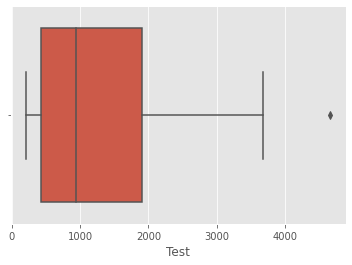

In [50]:
sns.boxplot(b)
# box plot для тестовой группы
print('Медиана дохода в тестовой группе B:', round(b.median(), 0))
# расчет медианы тестовой группы

In [51]:
a_mean = a.mean()
a_test  = test[is_test & is_revenue_more_0].revenue.std()

print('Средний доход в контрольной группе А:', round(a_mean, 2), 'со стандартным отклонением', round(a_test,1))
# считаем среднее в контрольной группе

Средний доход в контрольной группе А: 870.67 со стандартным отклонением 741.8


Медиана дохода в контрольной группе А: 698.0


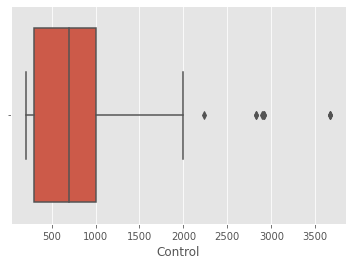

In [52]:
sns.boxplot(a)
# box plot для тестовой группы
print('Медиана дохода в контрольной группе А:', round(a.median(), 0))
# расчет медианы контрольной группы

In [53]:
stats.shapiro(test[is_control & is_revenue_more_0].revenue.sample(100, random_state=17))

(0.721470296382904, 1.7583150647287882e-12)

In [54]:
stats.shapiro(test[is_test & is_revenue_more_0].revenue.sample(100, random_state=17))

(0.873932421207428, 1.0135166661484618e-07)

На основании тестов Шапиро-Уилка, делаем вывод, что распределение дохода в группах A, B по клиентам -  не нормально (p-value < 0.05)

Рассмотрим распределения дохода по разным группам и посчитаем конверсию в каждой из групп

In [57]:
#df['Name'] = df['First'].str.cat(df['Last'], sep =" ")
test['combinations'] = test.group.str.cat(test.country, sep =" / ")
test.head()

,user_id,country,platform,sex,revenue,group,paid_user,combinations
0,8029,Russia,ios,male,0.0,B,0,B / Russia
1,1735,Sweden,ios,male,0.0,B,0,B / Sweden
2,7697,Russia,android,male,0.0,B,0,B / Russia
3,1421,Sweden,android,female,0.0,B,0,B / Sweden
4,1704,Russia,ios,male,0.0,B,0,B / Russia


In [69]:
test['combinations'] = test.country.str.cat(test.platform, sep =" / ")
test.head()

,user_id,country,platform,sex,revenue,group,paid_user,combinations
0,8029,Russia,ios,male,0.0,B,0,Russia / ios
1,1735,Sweden,ios,male,0.0,B,0,Sweden / ios
2,7697,Russia,android,male,0.0,B,0,Russia / android
3,1421,Sweden,android,female,0.0,B,0,Sweden / android
4,1704,Russia,ios,male,0.0,B,0,Russia / ios


In [70]:
test['combinations'] = test.combinations.str.cat(test.sex, sep =" / ")
test.head()

,user_id,country,platform,sex,revenue,group,paid_user,combinations
0,8029,Russia,ios,male,0.0,B,0,Russia / ios / male
1,1735,Sweden,ios,male,0.0,B,0,Sweden / ios / male
2,7697,Russia,android,male,0.0,B,0,Russia / android / male
3,1421,Sweden,android,female,0.0,B,0,Sweden / android / female
4,1704,Russia,ios,male,0.0,B,0,Russia / ios / male


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

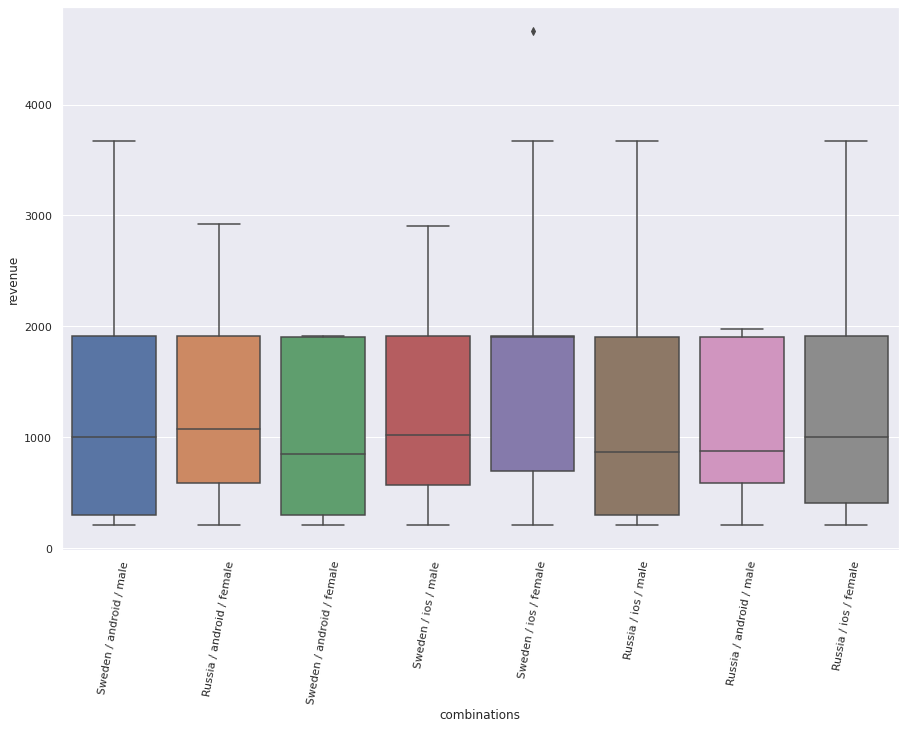

In [89]:
sns.boxplot(x='combinations', y='revenue', data=test[is_revenue_more_0])
plt.xticks(rotation=80)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

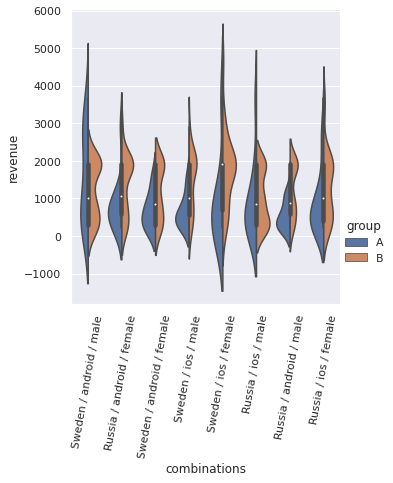

In [87]:
sns.catplot(x='combinations', y='revenue', hue='group', 
            kind="violin", split=True, data=test[is_revenue_more_0])

plt.xticks(rotation=80)

In [95]:
pivot_table = test.groupby(['combinations', 'group', 'paid_user'], as_index=False)\
    .agg({'user_id' : 'count'})\
    .rename(columns = {'user_id' : 'purchase_count'})\
    .pivot(index='combinations', columns={'paid_user','group'}, values='purchase_count')

pivot_table

group                        A         B    
paid_user                    0   1     0   1
combinations                                
Russia / android / female  256  11  1161  49
Russia / android / male    235   8  1214  54
Russia / ios / female      161  13   968  45
Russia / ios / male        220  11   952  49
Sweden / android / female  156   6   629  33
Sweden / android / male    148  14   614  33
Sweden / ios / female      143   7   480  27
Sweden / ios / male        141   8   471  24

In [96]:
pivot_table = pivot_table.stack(level=-2)

pivot_table

paid_user                           0   1
combinations              group          
Russia / android / female A       256  11
                          B      1161  49
Russia / android / male   A       235   8
                          B      1214  54
Russia / ios / female     A       161  13
                          B       968  45
Russia / ios / male       A       220  11
                          B       952  49
Sweden / android / female A       156   6
                          B       629  33
Sweden / android / male   A       148  14
                          B       614  33
Sweden / ios / female     A       143   7
                          B       480  27
Sweden / ios / male       A       141   8
                          B       471  24

In [97]:
pivot_table['сonversion'] =  round(pivot_table[1] / pivot_table[0] * 100, 3)

pivot_table

paid_user                           0   1  сonversion
combinations              group                      
Russia / android / female A       256  11       4.297
                          B      1161  49       4.220
Russia / android / male   A       235   8       3.404
                          B      1214  54       4.448
Russia / ios / female     A       161  13       8.075
                          B       968  45       4.649
Russia / ios / male       A       220  11       5.000
                          B       952  49       5.147
Sweden / android / female A       156   6       3.846
                          B       629  33       5.246
Sweden / android / male   A       148  14       9.459
                          B       614  33       5.375
Sweden / ios / female     A       143   7       4.895
                          B       480  27       5.625
Sweden / ios / male       A       141   8       5.674
                          B       471  24       5.096

In [71]:
from statsmodels.stats.contingency_tables import StratifiedTable

In [98]:
StratifiedTable.from_data('group', 'paid_user', 'combinations', test).summary()

,Estimate,LCB,UCB
Pooled odds,0.914,0.708,1.179
Pooled log odds,-0.090,-0.345,0.165
Pooled risk ratio,0.996,,
,,,
,Statistic,P-value,
Test of OR=1,0.478,0.489,
Test constant OR,6.232,0.513,
,,,
Number of tables,8,,
Min n,644,,


Критерий Кохрана-Мантеля-Ханзеля для проверки дисбаланса: p-value(Test of OR=1) > 0.05, а значит переменные независимы, и  p-value(Test constant OR) > 0.05 значит, что стратифицируемая переменная(комбинации пользователей по странам/платформам/полу) на них тоже не влияет.

Вопрос, есть ли статистически значимое различие между доходом в контрольной и тестовой группах.

С учетом того, что наши распрделения не являются нормальными, то можно оценивать эксперимент несколькими способами:

1. Непараметрический критерий Манна-Уитни
2. Критерий Стьюдента после взятия логарифма( который вероятно исправит ситуацию с нормальностью распрдеделения)
3. Бутстрап

Интерпретация критерия Манна-Уитни не очень удобна, поскольку основывается на медиане, а не на среднем, в случае дохода - среднее более удобная  и понятная метрика.

Логарифмирование и критерий Стьюдента не удобны из-за сложности интерепретации результата, так как работаем реально с log-выручкой.

Самый простой в данном случае - это бутсрап по среднему значению дохода.

* Бутстрап (с np.mean) для тестовой и контрольной групп пользователей 

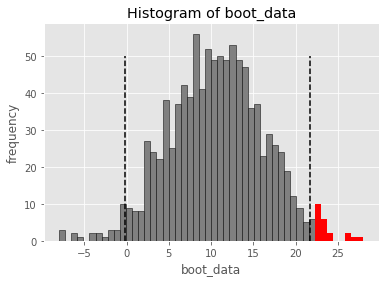

In [56]:
booted_data_users = get_bootstrap(test[is_test].revenue, test[is_control].revenue)

In [57]:
print('bootstrap (np.mean) p-value:', booted_data_users["p_value"])

bootstrap (np.mean) p-value: 0.056800603393270394


In [58]:
booted_data_users["quants"]

,0
0.025,-0.127947
0.975,21.654142


In [59]:
comparisson_Pvalue(booted_data_users["p_value"])

По полученному p-value > 0.05 не можем отклонить нулевую гипотезу, т.е. распределения выборок не имеют статически значимых различий.


Комментарий.

В данной проверке бутстрапом, возникает интересный момент, когда проводишь оценку статистической значимости, то значение p-value колеблется около 0.05, что полноценно не позволяет отклонить нулевую гипотезу. Поэтому добавила еще исследование на статистическую значимость критерием Манна-Уитни.

In [61]:
rez_MW = stats.mannwhitneyu(test[is_test].revenue, test[is_control].revenue, use_continuity=True)

In [62]:
print('mann-whitney p-value:', rez_MW[1])

mann-whitney p-value: 0.25169342201340217


In [63]:
comparisson_Pvalue(rez_MW[1])

По полученному p-value > 0.05 не можем отклонить нулевую гипотезу, т.е. распределения выборок не имеют статически значимых различий.


* Бутстрап (с np.mean) для тестовой и контрольной групп клиентов 

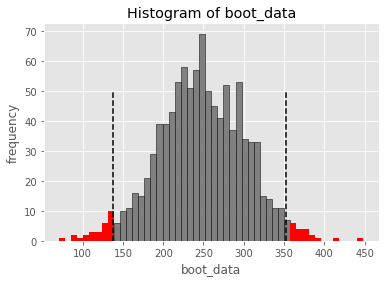

In [72]:
booted_data_clients = get_bootstrap(test[is_test & is_revenue_more_0].revenue, test[is_control & is_revenue_more_0].revenue)

In [73]:
print('bootstrap (clients) p-value:', booted_data_clients["p_value"])

bootstrap (clients) p-value: 3.603454410305037e-06


In [74]:
booted_data_clients["quants"]

,0
0.025,137.464574
0.975,352.513767


In [75]:
comparisson_Pvalue(booted_data_clients["p_value"])

По полученному p-value < 0.05 можем отклонить нулевую гипотезу, т.е. распределения выборок имеют статически значимые различия.


In [99]:
users_B = test[is_test].user_id.nunique()

print('Количество пользователей в тестовой группе:', users_B)

Количество пользователей в тестовой группе: 6923


In [100]:
paid_users_B = test[is_test].query('paid_user == 1').user_id.nunique()

print('Количество клиентов в тестовой группе:', paid_users_B)

Количество клиентов в тестовой группе: 434


In [101]:
users_A = test[is_control].user_id.nunique()

print('Количество пользователей в контрольной группе:', users_A)

Количество пользователей в контрольной группе: 1567


In [102]:
paid_users_A = test[is_control].query('paid_user == 1').user_id.nunique()

print('Количество клиентов в контрольной группе:', paid_users_A)

Количество клиентов в контрольной группе: 107


#### Конверсия

In [103]:
Conversion_B = paid_users_B/users_B *100

print('Конверсия в тестовой группе:: ', round(Conversion_B, 2), '%', sep='')

Конверсия в тестовой группе:: 6.27%


In [104]:
Conversion_A = paid_users_B/users_B *100

print('Конверсия в контрольной группе:: ', round(Conversion_A, 2), '%', sep='')

Конверсия в контрольной группе:: 6.27%


In [105]:
comparison_A_B(Conversion_B, Conversion_A)

Не изменилось


#### ARPU

In [114]:
ARPU_B = test[is_test].revenue.sum()/users_B

print('ARPU в тестовой группе: ', round(ARPU_B, 2), '$', sep='')

ARPU в тестовой группе: 70.14$


In [115]:
ARPU_A = test[is_control].revenue.sum()/users_A

print('ARPU в контрольной группе: ', round(ARPU_A, 2), '$', sep='')

ARPU в контрольной группе: 59.45$


In [116]:
comparison_A_B(ARPU_B, ARPU_A)

Увеличилось на 17.98% в тестовой группе по сравнению с контрольной


#### ARPPU

In [117]:
ARPPU_B = test[is_test].query('paid_user == 1').revenue.sum()/paid_users_B

print('ARPPU в тестовой группе: ', round(ARPPU_B, 2), '$', sep='')

ARPPU в тестовой группе: 1118.84$


In [118]:
ARPPU_A = test[is_control].query('paid_user == 1').revenue.sum()/paid_users_A

print('ARPPU в контрольной группе: ', round(ARPPU_A, 2), '$', sep='')

ARPPU в контрольной группе: 870.67$


In [119]:
comparison_A_B(ARPPU_B, ARPPU_A)

Увеличилось на 28.5% в тестовой группе по сравнению с контрольной


### Результаты 

В ходе исследования результатов A/B тестирования было получено:
1. Bootstrap тест по среднему для пользователей дает p-value > 0.05, что не позволяет отклонить нулевую гипотезу и считать статистически незначимыми различия в двух выборках.
2. Bootstrap тест по среднему для клиентов дает p-value < 0.05, что позволяет отклонить нулевую гипотезу и считать статистически значимыми различия в двух выборках.
2. Конверсия в тестовой и контрольной группе - одинаковая
3. ARPU увеличилось на 17.98%   в тестовой по сравнению с контрольной.
4. ARPPU увеличились на 28.5% в тестовой по сравнению с контрольной.

### Выводы:
Полученнные результаты свидетельствуют о том, что
1. Новая модель оплаты увеличивает средний доход, ARPU и ARPPU. 
2. При этом конверсия из пользователя в клиента не изменилась, следовательно новых клиентов не появилось.

Учитывая тот факт, что изменения рассматриваемые в A/B тесте были связаны с новой моделью оплаты коллекций шаблонов, то полученные результаты хорошо согласуются. Клиенты - те кто готов платить и приходят в приложение именно с этой целью и именно их средний  доход увеличился. Было показано, что данное изменение является статистически значимым. Пользователи же в принципе не все и не всегда доходят до формы оплаты, изменение которой рассматривается. Поэтому маловероятно, что оно могло повлиять на конверсию пользователя в клиента, а как следствие и на средний доход от пользователей.

3. Новую модель оплаты рекомендуется выкатить на остальных пользователей.

## Задание 2

Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

Предложите метрики, которые помогли бы ему отслеживать вовлеченность пользователей и принимать оптимальные решения. Какую основную информацию вы бы отразили на дашборде? На какие метрики стоит обратить внимание в первую очередь? Почему?

#### Решение

Считается, что пользовательская вовлеченность напрямую связана с монетизацией. Разделяют подходы к вовлеченности, как к результату (пользователь вовлекся и стал больше нажимать / рекомендовать / покупать) и как к процессу. В нашем случае рассматривается приложение для обработки и оформления фотографий в формате Stories, и здесь важно не как долго пользователь обрабатывает фотографии и какими способами, а результат: конкретная обработка изображения, удовлетворяющая потребности пользователя. То есть приложение открывается, когда необходимо получить конкретный результат, и закрывается, когда задача завершена. В данной ситуации важно анализивароть именно маркетинговую вовлеченность. В общем случае она состоит из следующих пунктов:

1. Осведомленность: количество новых пользователей/клиентов
2. Удовлетворенность: комментарии и обратная связь
3. Лояльность: количество сессий и их продолжительность, частота и периодичность возвратов
4. Вовлеченность: количество репостов, лайков; размер, создаваемого контента; количество приглашенных друзей и т.п..

Поскольку в данных нет информации о временных интервалах, а также о количестве транзакций, то на текущем дашборде невозможно отобразить временные метрики, такие как MAU, WAU, DAU, retention. 

Целевым действием в данном контексте является совершеннная транзакция(покупка). На дашборде  я бы предложила отразить количество активных пользователей, количество клиентов, конверсию из пользователя в клиента и финансовые метрики: ARPU, ARPPU, доход. Ключевыми метриками, на мой взгляд, здесь явлются конверсия из пользователя в клиента и средняя выручка на одного платящего пользователя. Именно они отвечают за потенциальный доход от приложения. Чем больше конверсия, тем больше новых клиентов, готовых платить за продукт, что повлечет за собой увеличение выручки. Если каждый клиент платит больше, то и выручка будет расти. На мой взгляд для руководителя важно видеть те категории клиентов, которые приносят максимальную выручку, и тех, кто чаще становятся клиентами.


Дашборд приложен отдельным файлом FP-4.twbx к заданию.

Комментарий. На дашборде есть визуализация treemap, в которой цвет отражает значение конверсии для каждой подкатегории(чем насыщеннее желтый, тем выше коэффициент конверсии), а размер - значение ARPPU( чем больше значение, тем больше прямоугольник). Также хочу отметить, что из-за присутствия клиентов без указанных страны, пола и типа платформы, средний коэффициент конверсии для всех активных пользователей оказывается выше, чем если смотреть на конверсию в каждой отдельной группе. Это происходит из-за того, что для этих клиентов конверсия равна 100%.
